# agumentation 프로젝트

## library import

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
#gpu check
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## dataset donwload

https://www.tensorflow.org/datasets/catalog/stanford_dogs  
Stanford Dogs 데이터 세트에는 전 세계 120 종의 개 이미지

In [3]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


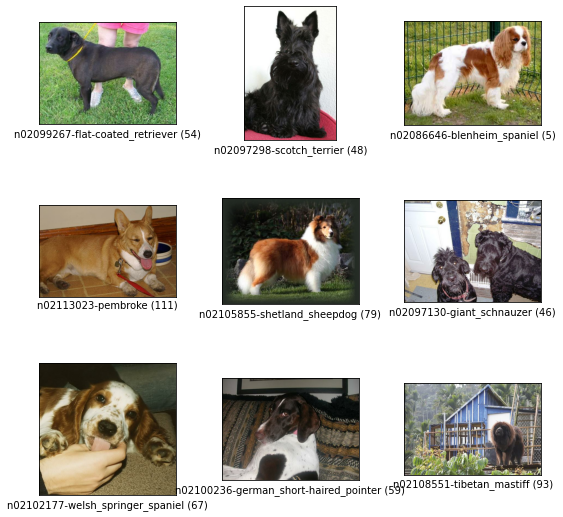

In [4]:
fig = tfds.show_examples(ds_info, ds_train)

## 텐서플로우 Random Augmentation API 

- random_brightness()
- random_contrast()
- random_crop()
- random_flip_left_right()
- random_flip_up_down()
- random_hue()
- random_jpeg_quality()
- random_saturation()



In [5]:
## 전처리 함수
## 이미지 norm
## 리사이즈 224
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [6]:
## arg 함수선언

## 좌우 반전, 밝기 조정.
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

In [7]:
##  tf.data.Datasets.map()



# 데이터셋(ds)을 가공하는 메인함수
# test 데이터는<< aug 랑 셔플 안함.
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용(위에 선언한.)
        num_parallel_calls=2
    )
    if not is_test and with_aug: # test는 적용하지 않음.
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test: # test아니면 섞어
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

## 비교하기 ( argu 한거랑 안한거랑)

In [8]:
##

In [9]:
# ResNet50 model import , data image net
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, # 마지막< <fully connected layer 포함 여부.
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [10]:
# aug 용으로 하나더 improt
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [136]:
# apply_normalize_on_dataset 함수 적용, with aug로 트리거 사용

# data load
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)

ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

In [138]:
ds_train_no_aug

<PrefetchDataset shapes: ((16, 224, 224, 3), (16, 120)), types: (tf.float32, tf.float32)>

In [139]:
ds_train_aug

<PrefetchDataset shapes: ((16, 224, 224, 3), (16, 120)), types: (tf.float32, tf.float32)>

In [12]:
# model train, <rjawmd

tf.random.set_seed(2020)
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
  2/750 [..............................] - ETA: 1:02 - loss: 5.3093 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0659s vs `on_train_batch_end` time: 0.1015s). Check your callbacks.


750/750 [==============================] - 128s 170ms/step - loss: 2.2180 - accuracy: 0.4451 - val_loss: 3.1524 - val_accuracy: 0.2478
Epoch 2/20
750/750 [==============================] - 129s 173ms/step - loss: 0.7726 - accuracy: 0.7824 - val_loss: 1.1762 - val_accuracy: 0.6568
Epoch 3/20
750/750 [==============================] - 131s 174ms/step - loss: 0.2980 - accuracy: 0.9287 - val_loss: 1.0602 - val_accuracy: 0.6947
Epoch 4/20
750/750 [==============================] - 133s 177ms/step - loss: 0.1180 - accuracy: 0.9799 - val_loss: 0.9933 - val_accuracy: 0.7165
Epoch 5/20
750/750 [==============================] - 129s 172ms/step - loss: 0.0535 - accuracy: 0.9948 - val_loss: 0.9474 - val_accuracy: 0.7334
Epoch 6/20
750/750 [==============================] - 130s 173ms/step - loss: 0.0313 - accuracy: 0.9976 - val_loss: 0.9267 - val_accuracy: 0.7383
Epoch 7/20
750/750 [==============================] - 130s 174ms/step - loss: 0.0222 - accuracy: 0.9991 - val_loss: 0.9401 - val_accura

750/750 [==============================] - 132s 175ms/step - loss: 2.2323 - accuracy: 0.4367 - val_loss: 2.8418 - val_accuracy: 0.3047
Epoch 2/20
750/750 [==============================] - 130s 173ms/step - loss: 0.9679 - accuracy: 0.7222 - val_loss: 1.2985 - val_accuracy: 0.6245
Epoch 3/20
750/750 [==============================] - 130s 173ms/step - loss: 0.5163 - accuracy: 0.8578 - val_loss: 1.1678 - val_accuracy: 0.6669
Epoch 4/20
750/750 [==============================] - 130s 174ms/step - loss: 0.2875 - accuracy: 0.9300 - val_loss: 1.0099 - val_accuracy: 0.7074
Epoch 5/20
750/750 [==============================] - 130s 174ms/step - loss: 0.1736 - accuracy: 0.9624 - val_loss: 1.0121 - val_accuracy: 0.7211
Epoch 6/20
750/750 [==============================] - 130s 174ms/step - loss: 0.0976 - accuracy: 0.9825 - val_loss: 0.9882 - val_accuracy: 0.7259
Epoch 7/20
750/750 [==============================] - 131s 175ms/step - loss: 0.0608 - accuracy: 0.9918 - val_loss: 0.9923 - val_accura

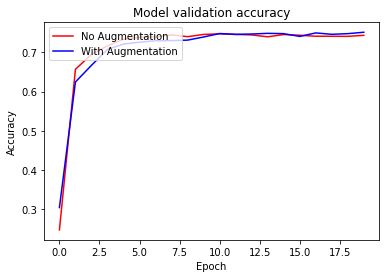

In [113]:
## 시각화
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

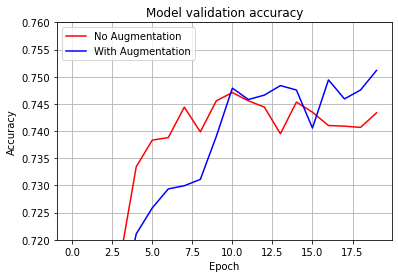

In [114]:
## 시각화 확대(1)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76)
plt.show()

## cut mix

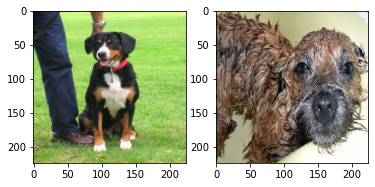

In [23]:
# 이미지 로드 2개
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

In [13]:
#

In [32]:
def get_clip_box(image_a, image_b, img_size=224):
    # get center of box
    x = tf.cast( tf.random.uniform([],0, img_size),tf.int32)
    y = tf.cast( tf.random.uniform([],0, img_size),tf.int32)

    # get width of box
    _prob = tf.random.uniform([],0,1)
    width = tf.cast(img_size * tf.math.sqrt(1-_prob),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-width//2)
    yb = tf.math.minimum(img_size, y+width//2)
    xb = tf.math.minimum(img_size, x+width//2)
    
    return xa, ya, xb, yb

xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(103, shape=(), dtype=int32) tf.Tensor(147, shape=(), dtype=int32)


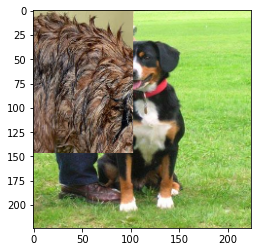

In [33]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb, img_size=224):
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:img_size,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:img_size,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

In [34]:
# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, img_size=224, num_classes=120):
    mixed_area = (xb-xa)*(yb-ya)
    total_area = img_size*img_size
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.3017578, 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
   

In [274]:
## 잘 못되어있었음..


# def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
#     mixed_imgs = []
#     mixed_labels = []

#     for i in range(batch_size):
#         image_a = image[i]
#         label_a = label[i]
#         j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
#         image_b = image[j]
#         label_b = label[j]
#         xa, ya, xb, yb = get_clip_box(image_a, image_b)
#         mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
#         mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

#     mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
#     mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
#     return mixed_imgs, mixed_label

In [ ]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        idx = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_a = image[i]
        image_b = image[idx]
        label_a = label[i]
        label_b = label[idx]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

## mix-up`

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.3017578 0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.6982422
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0

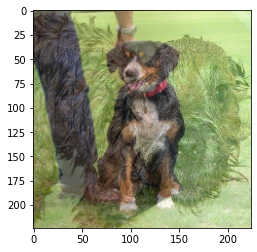

In [36]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

mixed_img, _ = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
print(mixed_label)

In [58]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

## Project . cutmix vs mix-up 비교

### 전처리 함수 선언

In [59]:
def onehot(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    imgs = []
    labels = []

    for i in range(batch_size):
        imgs.append(image[i])
        labels.append(tf.one_hot(label[i], num_classes))

    onehot_imgs = tf.reshape(tf.stack(imgs),(batch_size, img_size, img_size, 3))
    return onehot_imgs, labels


In [245]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, 
                               with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    print(batch_size)
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix: # cutmix
        ds = ds.map(
            cutmix,
            #num_parallel_calls=2
        )
        print("메-----롱")
    elif not is_test and with_mixup: # mixup
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
        print("2222222")
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    print(ds)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [246]:
# data set
# 1. cut mix 적용 data
# 2. mixup 적용 data

# 3, 1,2 각각 모델 만들기
# 4 모델 훈련하기
# 5. 각모델 훈련 시각화
# 6. No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 
#     대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교

### data load

In [264]:
# data load
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)



In [265]:
ds_train

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [266]:
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)

ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

In [267]:
ds_train_cutmix

<PrefetchDataset shapes: ((16, 224, 224, 3), (16, 120)), types: (tf.float32, tf.float32)>

In [268]:
ds_train_mixup

<PrefetchDataset shapes: ((16, 224, 224, 3), (16, 120)), types: (tf.float32, tf.float32)>

In [269]:
ds_test

<PrefetchDataset shapes: ((16, 224, 224, 3), (16, 120)), types: (tf.float32, tf.float32)>

### model define(res50)

In [270]:
# cutmix용 

num_classes = ds_info.features["label"].num_classes


cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])



In [271]:

mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, # 마지막< <fully connected layer 포함 여부.
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

### 모델 train

In [272]:
# model train, <rjawmd

tf.random.set_seed(2020)

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)



In [273]:
history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, ###########
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
  2/750 [..............................] - ETA: 1:24 - loss: 4.8956 - accuracy: 0.0312WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0491s vs `on_train_batch_end` time: 0.0897s). Check your callbacks.


750/750 [==============================] - ETA: 0s - loss: 3.8037 - accuracy: 0.2142WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0084s vs `on_test_batch_end` time: 0.0418s). Check your callbacks.


750/750 [==============================] - 139s 185ms/step - loss: 3.8037 - accuracy: 0.2142 - val_loss: 3.6709 - val_accuracy: 0.1574
Epoch 2/20
750/750 [==============================] - 135s 181ms/step - loss: 2.9193 - accuracy: 0.4373 - val_loss: 1.3697 - val_accuracy: 0.6165
Epoch 3/20
750/750 [==============================] - 136s 182ms/step - loss: 2.6283 - accuracy: 0.5293 - val_loss: 1.2947 - val_accuracy: 0.6378
Epoch 4/20
750/750 [==============================] - 125s 167ms/step - loss: 2.4385 - accuracy: 0.5860 - val_loss: 1.1648 - val_accuracy: 0.6693
Epoch 5/20
750/750 [==============================] - 117s 156ms/step - loss: 2.2778 - accuracy: 0.6442 - val_loss: 1.2814 - val_accuracy: 0.6568
Epoch 6/20
750/750 [==============================] - 125s 167ms/step - loss: 2.1553 - accuracy: 0.6796 - val_loss: 1.2716 - val_accuracy: 0.6559
Epoch 7/20
750/750 [==============================] - 118s 157ms/step - loss: 2.0863 - accuracy: 0.6982 - val_loss: 1.1930 - val_accura

In [119]:
history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
  2/750 [..............................] - ETA: 1:26 - loss: 4.9715 - accuracy: 0.0312    WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0471s vs `on_train_batch_end` time: 0.0784s). Check your callbacks.


750/750 [==============================] - ETA: 0s - loss: 3.7060 - accuracy: 0.2441WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0072s vs `on_test_batch_end` time: 0.0372s). Check your callbacks.


750/750 [==============================] - 136s 182ms/step - loss: 3.7060 - accuracy: 0.2441 - val_loss: 4.3093 - val_accuracy: 0.0981
Epoch 2/20
750/750 [==============================] - 136s 181ms/step - loss: 2.8835 - accuracy: 0.4748 - val_loss: 1.4893 - val_accuracy: 0.5799
Epoch 3/20
750/750 [==============================] - 136s 181ms/step - loss: 2.5884 - accuracy: 0.5781 - val_loss: 1.5601 - val_accuracy: 0.5705
Epoch 4/20
750/750 [==============================] - 137s 182ms/step - loss: 2.3776 - accuracy: 0.6620 - val_loss: 1.3842 - val_accuracy: 0.6116
Epoch 5/20
750/750 [==============================] - 137s 182ms/step - loss: 2.2769 - accuracy: 0.6959 - val_loss: 1.2380 - val_accuracy: 0.6561
Epoch 6/20
750/750 [==============================] - 137s 183ms/step - loss: 2.1861 - accuracy: 0.7299 - val_loss: 1.2795 - val_accuracy: 0.6512
Epoch 7/20
750/750 [==============================] - 134s 179ms/step - loss: 2.1064 - accuracy: 0.7657 - val_loss: 1.3838 - val_accura

In [ ]:
## augme

## cutmix / mixup 비교 시각화

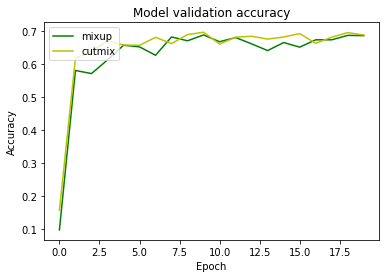

In [278]:


plt.plot(history_resnet50_mixup.history['val_accuracy'], 'g')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['mixup','cutmix'], loc='upper left')
plt.show()

## noarg / arg 비교 시각화

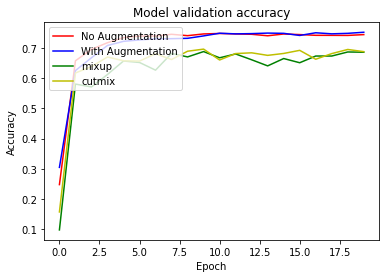

In [275]:

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'g')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation','mixup','cutmix'], loc='upper left')
plt.show()

In [ ]:
###
# 오히려 agumentation을 안했거나 많이 안한 모델이 더 높은 수치가 나왔다.
# 이미 충분한 데이터 수가 있어서인지 Agumentation을 한다고 꼭 더 나은 수치가 나오는것은 아닐지도 모르는것 같다.
# 한개의 클래스당 최소 1000개가 필요하다는 말이 있는데 데이터가 부족할떄는 Agumentation을 쓰면 더 효과가 있지 않을까 생각한다.